# Yelp Rating Prediction Model
Project Source from: Offerbang, Chris

Implementation: Zilin Chen

Date: 7/26/2022

### Introduction
This project works on real yelp review data, and does data preprocessing and feature engineering using bag-of-words. The goal is to build and train a multi-class logistic regression model from scratch to predict customer's rating based on their reviews. And the model will be evaluated using both hard and soft metrics.

In [1]:
import sys
import re
import json
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#set the file path for each file

#training set
f_train = 'reviews_train.json'
#validation set & label
f_dev = 'reviews_dev.json'
f_dev_labels = 'reviews_dev_labels.txt'
#test set
f_test = 'reviews_test.json'
#stop words
f_stop = 'stopword.list'

### Data Preprocessing and EDA

In [3]:
# We have implemented the stopwords loading for you
def load_stopwords(infile: str) -> set:
    with open(infile) as g:
        stopwords = set(map(lambda x:x.strip(), g.readlines()))
    print(f'{len(stopwords)} stopwords loaded')
    return stopwords

In [4]:
# stopwords are non-useful words to be filtered out
stopwords = load_stopwords(f_stop)


341 stopwords loaded


In [5]:
# TODO: complete the parse_text function, the function takes one comment string
#       and return a list of tokens(words)
def parse_text(text: str) -> List[str]:
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # TODO:
    # 1. convert all tokens into lower case
    # 2. remove tokens that in stopwords
    # 3. remvoe empty token like ''
    tokens = []
    for token in text.split():
        token = token.strip().lower()
        if token and token not in stopwords:
            tokens.append(token)
    return tokens

In [6]:
# TODO: complete preprocess function to load training/validation/test data from files
#       if label_file is not None, you should read label from the label file, 
#       otherwise, load label from data file, "text" field in each json object. 
def preprocess(data_file: str, label_file: str=None) -> Tuple[List[List[str]], List[int]]:
    review_list, star_list = [], []
    
    reviews = {}
    stars = {}
    with open(data_file, 'r') as f:
        for json_str in f:
            obj = json.loads(json_str)
            # TODO: 
            # 1. load the reivew_id and reivew text from JSON obj, which
            #   is a dictionary after loading to Python
            # 2. using the parse_text function to process the review text
            # 3. save the token list to review map: {review_id => tokens}
            review_id = obj['review_id']
            review = obj['text']
            tokens = parse_text(review)
            reviews[review_id] = tokens
            
            if label_file is None:
                # TODO:
                # 1. load the label (stars) from JSON obj
                # 2. save tokens and star to output list (i.e., review_list, start_list)
                star = int(obj['stars'])
                review_list.append(tokens)
                star_list.append(star)
                
    
    if label_file:
        # so we need to manually load stars from file
        # file format: review_id<space>stars
        with open(label_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            review_id, star = line.strip().split()
            stars[review_id] = int(star)

        for review_id, tokens in reviews.items():
            review_list.append(tokens)
            star_list.append(stars[review_id])
    
    return review_list, star_list

In [7]:
#load the training data
review_list, star_list = preprocess(f_train)

In [8]:
#review list should have the same length as star list
assert len(review_list) == len(star_list)

print(f'Number of training samples: {len(review_list)}')
print(len(star_list))

Number of training samples: 1255353
1255353


In [9]:
# TODO: implement this function to get the top 9 most frequent tokens
def get_top_token_counts(review_list: List[List[str]]) -> List[Tuple[str, int]]:
    
    ct = Counter()
    for token_list in review_list:
        ct.update(token_list)
    
    token_cnt_list = sorted(ct.items(), key=lambda x:x[1], reverse=True)
    
    for token, cnt in token_cnt_list[:9]:
        print(f'token={token}\tcount={cnt}')
    
    # We will write the token and its count to a file just
    # in case you need it :)
    with open('token_counts.txt', 'w') as f:
        for token, count in token_cnt_list:
            f.write(f'{token} {count}\n')
    return token_cnt_list

In [10]:
token_cnt_list = get_top_token_counts(review_list)

token=good	count=721552
token=place	count=706729
token=food	count=673892
token=great	count=573051
token=like	count=542963
token=just	count=518714
token=time	count=433290
token=service	count=411813
token=really	count=385354


In [13]:
# TODO: implement this function to get the star distribution on traning set
def get_label_counts(star_list: List[int]) -> List[int]:
    stars_count = [0] * 5 # 1-5 stars
    for star in star_list:
        stars_count[star-1] += 1
    
    print('star counts:', stars_count)
    print('distribution:', np.array(stars_count, dtype=float) / sum(stars_count))
    return stars_count

In [14]:
stars_count = get_label_counts(star_list)

star counts: [128038, 112547, 178215, 373469, 463084]
distribution: [0.10199362 0.08965367 0.14196405 0.29750118 0.36888748]


In [15]:
def plot_bar_chart(labels, values, title, ylabel):
    fig, ax = plt.subplots()
    ax.bar(labels, values)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

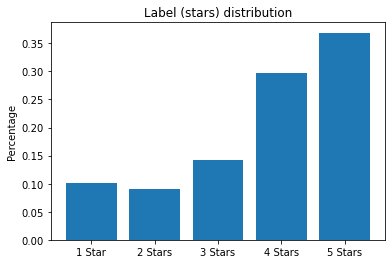

In [16]:
plot_bar_chart(
    labels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'],
    values=np.array(stars_count, dtype=float) / sum(stars_count),
    title='Label (stars) distribution',
    ylabel='Percentage'
)

### Feature Engineering

We use bag-of-words to construct features for our model.

In [17]:
DICT_SIZE = 500

In [24]:
# TODO: Create the feature map where each token is mapped to a fixed index between 0-499.
#       Also, make sure the token_cnt_list is sorted when you slice the top DICT_SIZE
def create_feat_map(token_cnt_list: List[Tuple[str, int]], dict_size: int) -> Dict[str, int]:
    feat_map = {}
    token_cnt_list.sort(key=lambda x:x[1], reverse=True)
    for i in range(DICT_SIZE):
        feat_map[token_cnt_list[i][0]] = i
    
    return feat_map

In [25]:
feat_map = create_feat_map(token_cnt_list, DICT_SIZE)

In [27]:
# TODO: implement the feature exatraction function to construct feature
#       vector for the given review list
def extract_feature(feat_map: Dict[str, int], review_list: List[List[str]]) -> np.ndarray:
    n_sample, n_feat = len(review_list), DICT_SIZE
    X = np.zeros((n_sample, n_feat))
    for i, tokens in enumerate(review_list):
        for token in tokens:
            if token in feat_map:
                X[i][feat_map[token]] += 1
        
    
    return X

In [28]:
#get the feature for train set
X_train, y_train = extract_feature(feat_map, review_list), star_list

In [30]:
#get the feature for validation set
dev_review_list, dev_star_list = preprocess(f_dev, f_dev_labels)
X_val, y_val = extract_feature(feat_map, dev_review_list), dev_star_list

### Model Implementation: Multi-class Logistic Regression

Letting $c\in \{1,2,3,...,C\}$ be the class-label indicator, we estimate the probability of the class as:

$$P(y=c|x;W)=\frac{e^{w_c^Tx}}{\sum_{c'=1}^C e^{w_{c'}^Tx}}$$

In [31]:
# let's first define our model parameter W and initialize it uniformly
W = np.ones((5, DICT_SIZE)) / DICT_SIZE

In [32]:
# TODO: implement this function to make prediction on one single instance, the output should be
#       the probability of all different class (e.g., [0.1, 0.1, 0.6, 0.15, 0.05])
def predict(W: np.ndarray, x: np.ndarray) -> np.ndarray:
    wT_x = np.dot(W, x)
    num = np.exp(wT_x)
    scores = num / np.sum(num)
    return scores

In [90]:
# Since each class has the same weight, your function should output 
# equal probability for any sample (e.g., [0.2 0.2 0.2 0.2 0.2])
fake_x = np.zeros(DICT_SIZE)
fake_x[DICT_SIZE-1] = 1.0
scores = predict(W, fake_x)
# y_i = convert_indicator(3)
# diff = y_i - scores
# print (diff.reshape((-1,1)))
# print (fake_x.reshape(1,-1))
print (scores)

[0.2 0.2 0.2 0.2 0.2]


Given a training set of labeled pairs $D=\{(x_i, y_i)\}_{i=1}^n$, we optimize the model parameters as:

$$W^* = \arg\max_W \prod_{i=1}^n P(y_i|x_i;W)$$

We use L2 Regularization, and we can write our regularized loss function as:

$$L(W)=-\frac{1}{n}\sum_{i=1}^n log P(y_i|x_i; W)+\frac{\lambda}{2}\sum_{i=1}^C\|w_i\|^2$$

#### Get the gradient of loss function 

In order to derive the gradient of our objective function (the regularized
conditional log-likelihood), it is convenient to redefine the output label of i-th input (i.e., $y_i$ ) using a indicator vector $y_i=(y_{i1}, y_{i2},..., y_{iC})^T$, whose elements are defined as

$$y_{ic}=\begin{cases}
1,& \text{if } y_i=c\\
    0,              & \text{otherwise}
\end{cases} $$

In [91]:
# TODO: implement the function to convert y=5 to indicator vector y_ind=[0,0,0,0,1]
def convert_indicator(y: int) -> np.ndarray:
    y_ind = np.zeros(5)
    y_ind[y-1] = 1.0
    return y_ind

In [92]:
print(convert_indicator(5))

[0. 0. 0. 0. 1.]


Then the conditional probability of $y_i$ given $x_i$ and $W$ can be written as:
$$P(y_i|x_i;W)=\prod_{c=1}^C \bigg(\frac{e^{w_c^Tx_i}}{\sum_{c'=1}^C e^{w_{c'}^Tx_i}} \bigg)^{y_{ic}}
$$

Now we want you to prove that the gradient of $L(W)$ with respect to vector $w_c$ (i.e., $\frac{\partial L(W)}{\partial w_c}$) is equal to:

$$-\frac{1}{n}\sum_{i=1}^n \bigg(y_{ic}-\frac{e^{w_c^Tx_i}}{\sum_{c'=1}^C e^{w_{c'}^Tx_i}} \bigg)x_i + \lambda w_c$$

In [100]:
#TODO: implement the function to calculate gradient for W with a single sample
#      so ignore the regularization part (\lambda * w_c) for now
def get_gradient(W: np.ndarray, x: np.ndarray, y: int) -> np.ndarray:
    y_i = convert_indicator(y)
    scores = predict(W, x)
    diff = y_i - scores
#     print (diff.shape, x.shape)
    grad = np.dot(diff.reshape((-1,1)), x.reshape(1,-1))    
    return -grad

In [101]:
# TODO: implement this function to perform one iteration of gradient descent
#       on a given batch of data, where lr is the learning rate and regul 
#       is the regularization parameter
def grad_update(W: np.ndarray, X_batch: List[np.ndarray], y_batch: List[int],
                lr: float=0.01, regul:float=0.1) -> np.ndarray:

    # the gradient should have the same shape as W
    batch_grad = np.zeros_like(W)
    
    for x, y in zip(X_batch, y_batch):
        grad = get_gradient(W, x, y)
        batch_grad += grad
    
    batch_grad /= len(X_batch)
    
    W -= lr * batch_grad + regul * W

    return W

In [102]:
# TODO: implement this function to compute accuracy for a given dataset (X, y)
def compute_accuracy(W: np.ndarray, X: np.ndarray, y: List[int]) -> None:
    err = 0
    for x, label in zip(X, y):
        prob = predict(W, x)
        y_i = prob.argmax() + 1 #find the true category
        if y_i != label:
            err += 1
    print(f'Accuracy is {1.0 - err / len(X)}')

In [103]:
# TODO: implement this function to compute log-loss for a given dataset (X, y)
def compute_loss(W: np.ndarray, X: np.ndarray, y: List[int], regul: float) -> None:
    loss = 0
    
    for x, label in zip(X, y):
        prob = predict(W, x)
        max_prob_idx = prob.argmax()
        loss += np.log(prob[max_prob_idx])
    
    loss = - loss / len(X) + regul * np.sum(np.square(W))  
        
    print(f'Loss is {loss}')

In [108]:
# TODO: use the tips above to complete this function for mini-batch GD model trainig
def train_RMLR(X_train: np.ndarray, y_train: List[int], batch_size: int,
               lr: float=0.01, regul:float =0.1) -> np.ndarray:
    print('Start training RMLR...')
    
    # randomly initialize W, you can use np.random.rand
    W = np.random.rand(5, DICT_SIZE)
    
    print('Initial performance')
    compute_loss(W, X_train, y_train, regul)
    compute_accuracy(W, X_val, y_val)
    
    n_batch = 0
    batch_X = []
    batch_y = []
    
    random_seq = [i for i in range(len(X_train))]
    
    while n_batch < 600: # add your stop criteria here
        for idx in random_seq[:batch_size]:
            # construct your mini-batch and start training
            batch_X.append(X_train[idx])
            batch_y.append(y_train[idx])
            
        W = grad_update(W, batch_X, batch_y, lr=lr, regul=regul)
        n_batch += 1
        batch_X = []
        batch_y = []

        if n_batch % 100 == 0:
            print ('evaluate at batch', n_batch)
            compute_loss(W, X_train, y_train, regul)
            compute_accuracy(W, X_val, y_val)
        
        np.random.shuffle(random_seq)
                  
    print('Training completed successfully!')
    return W

In [109]:
W = train_RMLR(X_train, y_train, batch_size=10000, lr=0.01)

Start training RMLR...
Initial performance
Loss is 84.0599757399288
Accuracy is 0.18017323737341573
evaluate at batch 100
Loss is 1.5691270158418251
Accuracy is 0.4361569326794472
evaluate at batch 200
Loss is 1.5694568604036918
Accuracy is 0.4379593656455003
evaluate at batch 300
Loss is 1.569186091315034
Accuracy is 0.4367237755556971
evaluate at batch 400
Loss is 1.5688868156057905
Accuracy is 0.4351633653907394
evaluate at batch 500
Loss is 1.5694706217134313
Accuracy is 0.4349468186739698
evaluate at batch 600
Loss is 1.5697321729327034
Accuracy is 0.4342462263550092
Training completed successfully!


### Model Evaluation

#### Hard Metrics
We will use per-class accuracy and overall accuracy in this case.

In [110]:
y_pred_train = [predict(W, x).argmax()+1 for x in X_train]
y_pred_val = [predict(W, x).argmax()+1 for x in X_val]

In [111]:
# TODO: implement the per-class accuracy and overall accuracy metrics, note
#       here the input is true label list and predicted label list
def multiclass_accuracy_score(y_true: List[int], y_pred: List[int]) -> None:
    count = Counter()
    err = Counter()
    n_count, n_err = 0, 0
    for y, y_hat in zip(y_true, y_pred):
        count[y] += 1
        n_count += 1
        if y != y_hat:
            err[y] += 1
            n_err += 1
    print(f'Overall accuracy: {1-n_err/n_count}')
    print(f'Per-class accuracy:')
    for star, cnt in sorted(count.items()):
        print(f'Star={star}, accuracy={1-err[star]/cnt}')

In [112]:
multiclass_accuracy_score(y_train, y_pred_train)
multiclass_accuracy_score(y_val, y_pred_val)

Overall accuracy: 0.43464029639471924
Per-class accuracy:
Star=1, accuracy=0.010356300473296942
Star=2, accuracy=0.0
Star=3, accuracy=0.0007406783940745454
Star=4, accuracy=0.45186347461235066
Star=5, accuracy=0.810677976349863
Overall accuracy: 0.4342462263550092
Per-class accuracy:
Star=1, accuracy=0.010059097196026712
Star=2, accuracy=0.0
Star=3, accuracy=0.0005799687709123758
Star=4, accuracy=0.45294928691455905
Star=5, accuracy=0.8073374001202852


#### Soft metrics
The soft metric is the Root Mean Square Error (RMSE) for your prediction results, which is defined as

$$\text{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^n(\hat{r}_i-r_i)^2}$$

where $\hat{r}_i$ is your predicted rating for i-th instance, $r_i$ is the corresponding true rating and $n$ is the size of dataset used for testing. The soft metric shows the average difference between your predictions and true ratings.

In [113]:
# TODO: implement the function to evaluate RMSE, here the input is also
#       two list of labels (true & predicted)
def root_mean_square_err(y_true: List[int], y_pred: List[int]) -> None:
    s = 0.0
    for y, y_hat in zip(y_true, y_pred):
        s += np.square(y_hat - y)

    print(f'RMSE={np.sqrt(s / len(y_true))}')

In [114]:
root_mean_square_err(y_train, y_pred_train)
root_mean_square_err(y_val, y_pred_val)

RMSE=1.5816439417944188
RMSE=1.578009911021339
